In [1]:
%config InlineBackend.figure_format = 'retina'
import os
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm; tqdm.pandas()
plt.style.use('seaborn')
cwd = os.getcwd()

from utility import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import category_encoders as ce
import shap

/Users/frank/.venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/frank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/frank/.venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Read in data
post = pd.read_csv(cwd+'/data/post_metrics_and_comments.csv')
htag = pd.read_csv(cwd+'/data/hashtag_top_appearances.csv')
rawp = pd.read_csv(cwd+'/data/raw_post_metrics.csv')
print('post_metrics_and_comments.csv has {} rows and {} columns'.format(post.shape[0],post.shape[1]))
print('hashtag_top_appearances.csv has {} rows and {} columns'.format(htag.shape[0],htag.shape[1]))
print('raw_post_metrics.csv has {} rows and {} columns'.format(rawp.shape[0],rawp.shape[1]))

post_metrics_and_comments.csv has 11637 rows and 11 columns
hashtag_top_appearances.csv has 25062 rows and 2 columns
raw_post_metrics.csv has 70532 rows and 5 columns


In [ ]:
post = post.merge(htag)
rawp = post.merge(rawp)

# Remove "|, @, #" in comments and translate into English
post['en_comment'] = post.concatenated_comments.progress_apply(process_comment)
trans(post)

# Calculate comments length and counts
post['comment_length'] = post.en_comment.progress_apply(len)
post['comment_count'] = post.concatenated_comments.progress_apply(lambda x: x.count('|'))

# Calculate emoji counts and emoji rates in comments
post['comment_emojicount'] = post.concatenated_comments.progress_apply(countemoji)
post['comment_emojirate'] = post.comment_emojicount / (post.comment_length+1)

# Calculate comments sentiment score
post['comment_sentiment'] = post.en_comment.progress_apply(sentiment)

# Calculate datetime and generate weekdays
post['weekday'] = post.date_posted.progress_apply(getweekday)
rawp['date_posted'] = rawp.date_posted.progress_apply(getdate1)
rawp['date_time_collected'] = rawp.date_time_collected.progress_apply(getdate2)

# Calculate likes & comments per day
rawp['daydelta'] = rawp.date_time_collected-rawp.date_posted
rawp['daydelta'] = rawp['daydelta'].dt.days
rawp = rawp.groupby(['post_url', 'max_likes', 'max_comments'], as_index=False)['daydelta'].max()
rawp = rawp[rawp.daydelta>=1]
rawp.loc[:,'likes_per_day'] = rawp.max_likes/rawp.daydelta
rawp.loc[:,'comments_per_day'] = rawp.max_comments/rawp.daydelta
post = rawp.merge(post)

# Calculate comments per likes for each posts
post['comments/likes'] = post.max_comments / (post.max_likes+1)

# Calculate posts per day
post_count = post[['username','date_posted']].groupby(['username'], 
            as_index=False).count().rename(columns={"date_posted": "post_counts"})
post = post.merge(post_count)
post['posts_per_day'] = post.post_counts / 26 # (from 4/1 to 4/26)

# Generate a classification target variable
post.loc[post.days_in_hashtag_top_section == 0 ,'trending'] = 0
post.loc[post.days_in_hashtag_top_section != 0 ,'trending'] = 1

#post.to_pickle("./post.pkl")

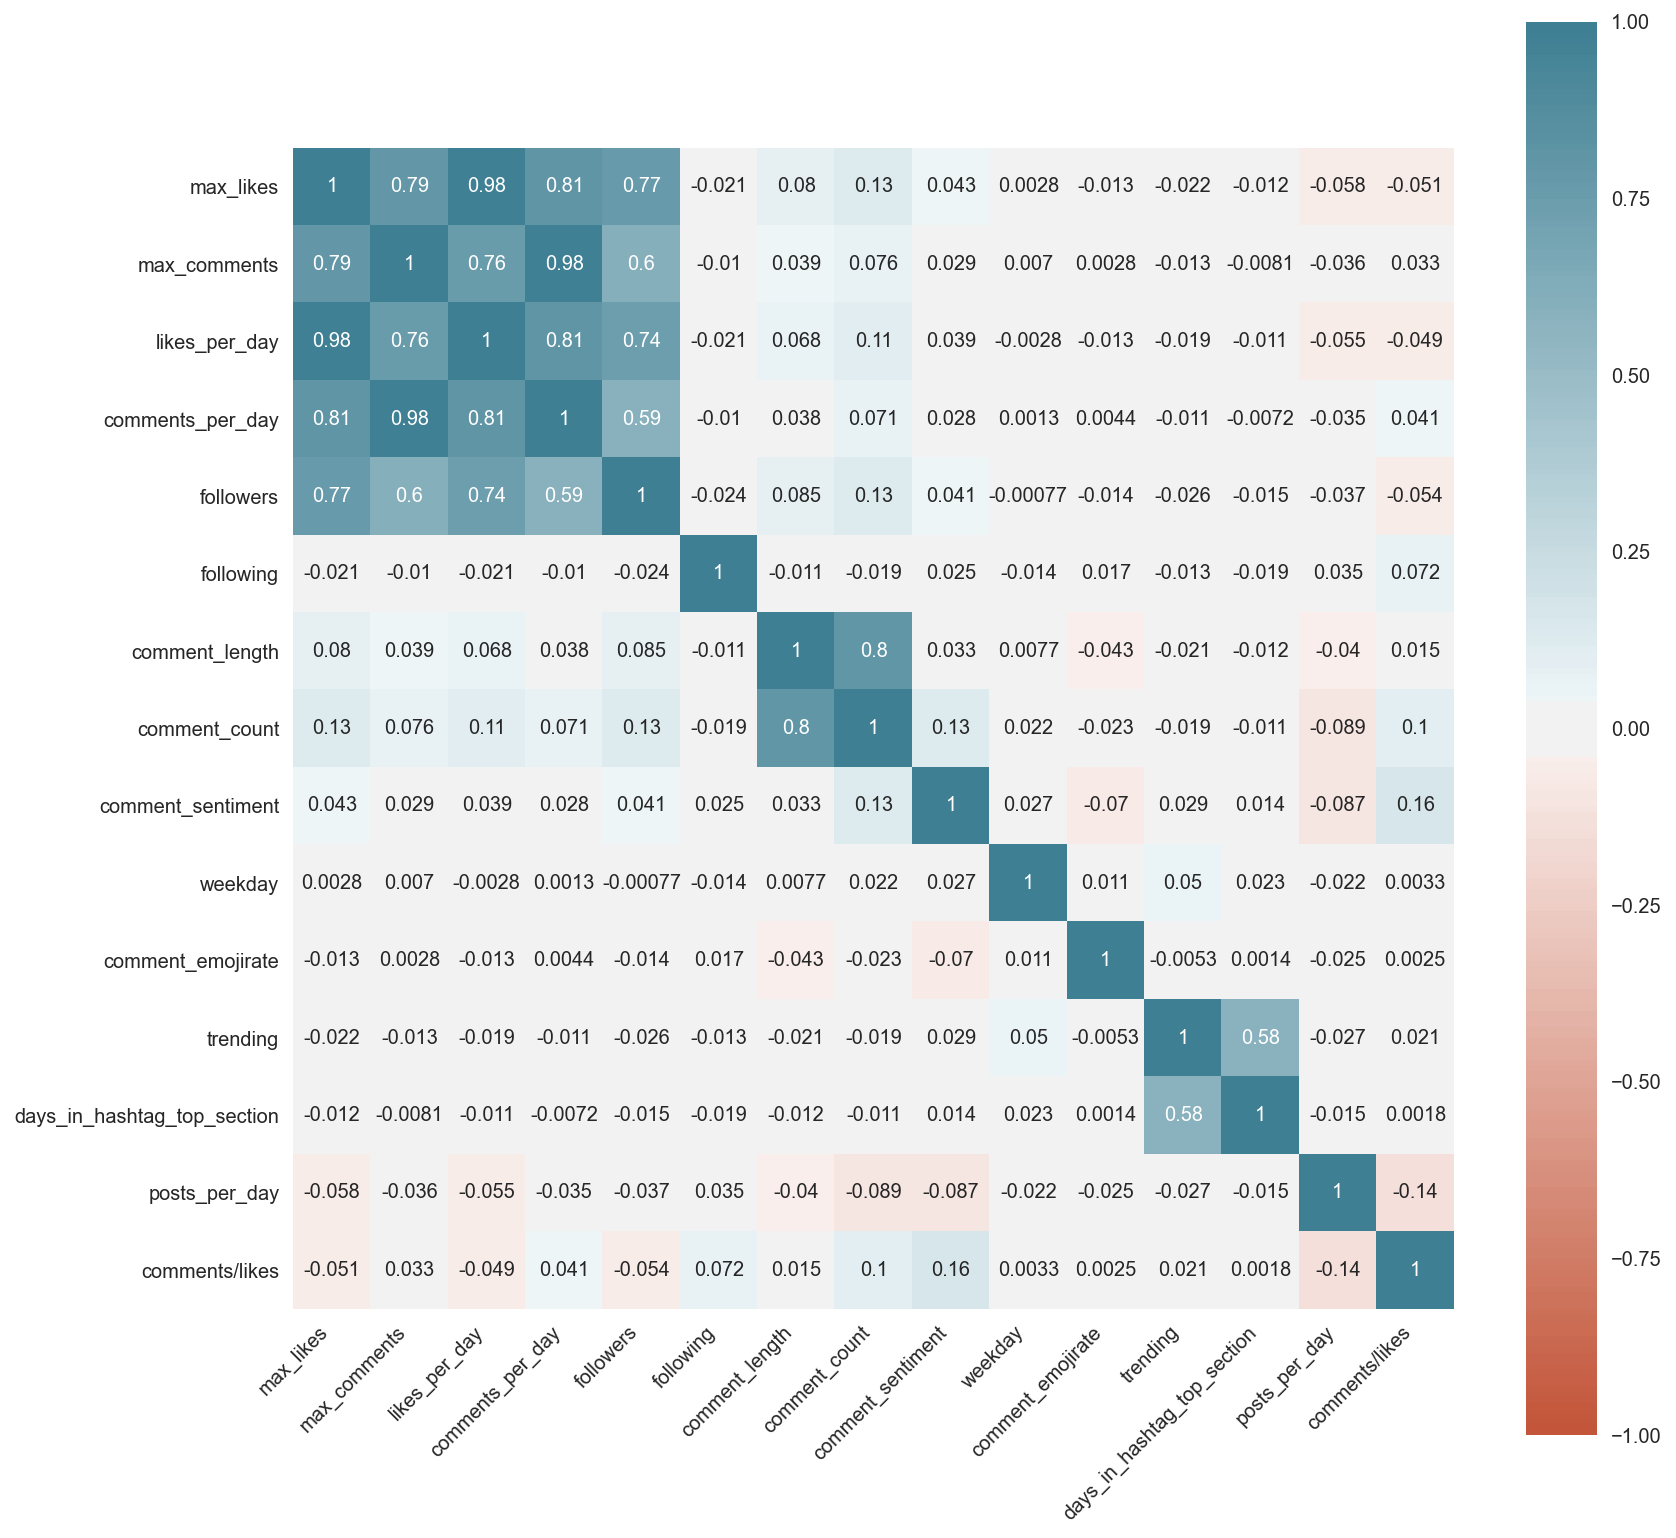

In [4]:
post = pd.read_pickle("./post.pkl")

data = post[['username', 'max_likes', 'max_comments', 'likes_per_day', 'comments_per_day',
             'followers', 'following', 'comment_length', 'comment_count', 'comment_sentiment', 
             'weekday', 'comment_emojirate', 'trending', 'days_in_hashtag_top_section', 
             'posts_per_day', 'comments/likes']]
# Plotting correlation matrix
fig = plt.figure(figsize=(13, 13))
ax = sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Classification

In [5]:
data = data[['username', 'max_likes', 'max_comments', 'likes_per_day', 'comments_per_day',
             'followers', 'following', 'comment_length', 'comment_count', 'comment_sentiment', 
             'weekday', 'comment_emojirate', 'trending', 'posts_per_day', 'comments/likes']]

X = data.drop(columns=['trending'])
y = data['trending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Target Encoder
encoder = ce.TargetEncoder(cols=['username'])
# Make sure to use only training data to train the encoder
X_trainec = encoder.fit_transform(X_train, y_train)
X_testec = encoder.transform(X_test)
X_ec = encoder.transform(X)

SS = StandardScaler()
X_trainec_norm = pd.DataFrame(data = SS.fit_transform(X_trainec), columns = X.columns)
X_testec_norm = pd.DataFrame(data = SS.transform(X_testec), columns = X.columns)
X_ec_norm = pd.DataFrame(data = SS.transform(X_ec), columns = X.columns)

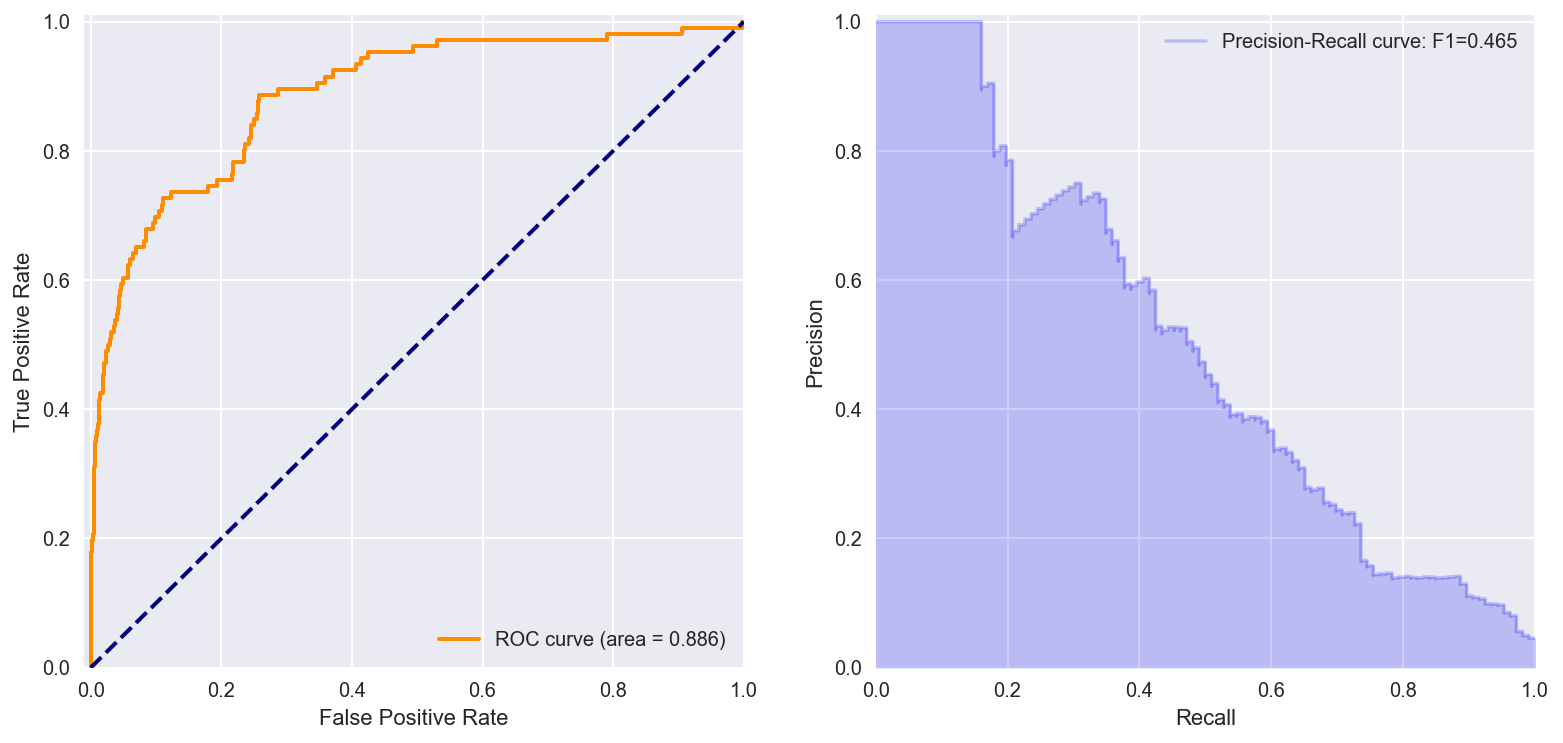

In [6]:
# Using grid search to tune the model
param = {'learning_rate': 0.1,
         'max_depth': 5,
         'min_child_samples': 10,
         'num_leaves': 32,
         'reg_alpha': 0,
         'reg_lambda': 0.8}
lgbm = LGBMClassifier(**param, n_jobs = -1, random_state=0)
y_pred = lgbm.fit(X_trainec_norm, y_train).predict_proba(X_testec_norm).T[1]
fig = plt.figure(figsize=(13, 6))
plot_curves(y_test, y_pred)

In [7]:
shap.initjs()
explainer = shap.TreeExplainer(lgbm)
shap_values = np.array(explainer.shap_values(X_trainec_norm))
IMP = pd.DataFrame({'Feature': X.columns.values,
    'Importance': np.absolute(shap_values[1]).mean(axis = 0)}).sort_values(by = 'Importance', ascending = False)
IMP

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,Feature,Importance
0,username,2.225218
4,comments_per_day,0.375295
3,likes_per_day,0.304788
1,max_likes,0.239113
2,max_comments,0.212204
8,comment_count,0.160434
5,followers,0.149117
7,comment_length,0.104278
11,comment_emojirate,0.090280
10,weekday,0.054562


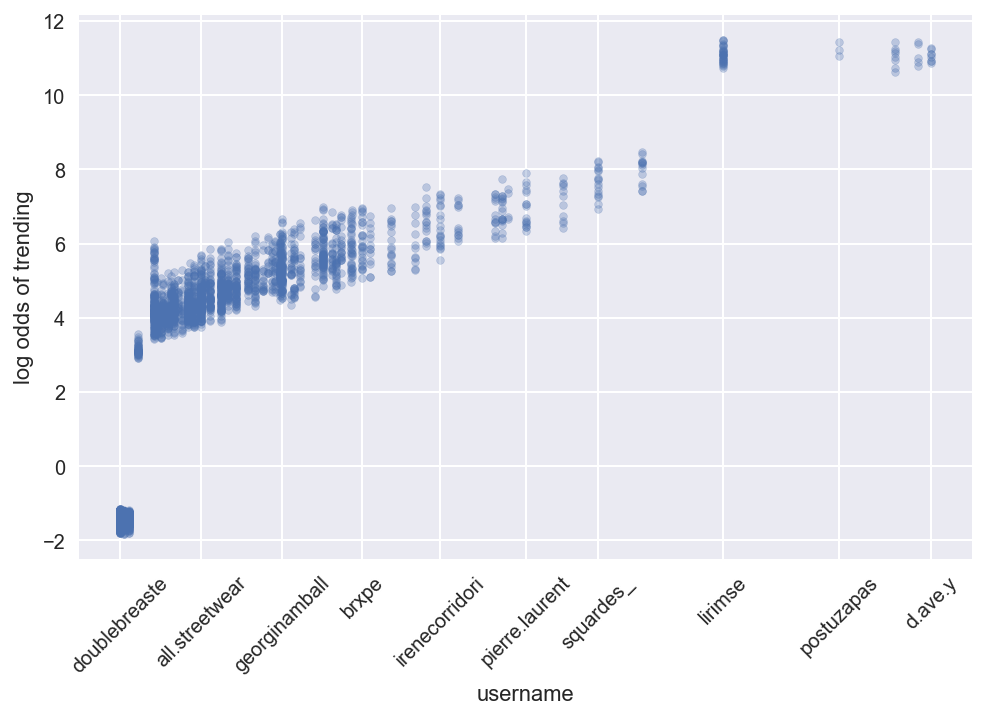

In [8]:
t = pd.DataFrame({'feat':X_trainec.username, 
                  'shap':shap_values[1].T[0]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
sample_idx = findindex(X_trainec)
plt.xticks(X_trainec.username[sample_idx], X_train.username[sample_idx], rotation = 45)
plt.xlabel('username'); plt.ylabel('log odds of trending')
plt.show()

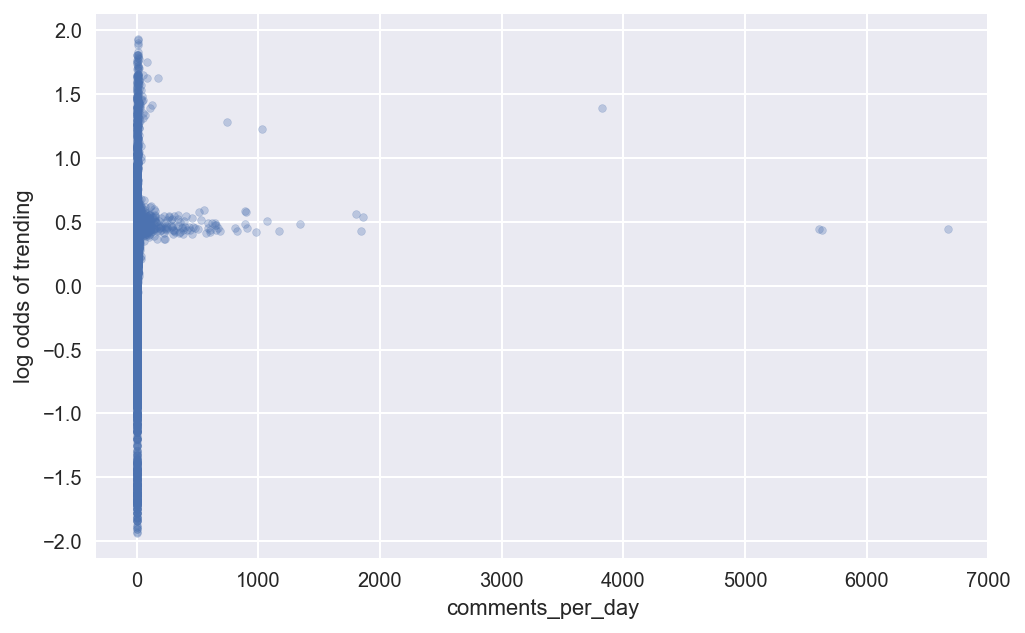

In [9]:
t = pd.DataFrame({'feat':X_trainec.comments_per_day, 
                  'shap':shap_values[1].T[4]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('comments_per_day'); plt.ylabel('log odds of trending')
plt.show()

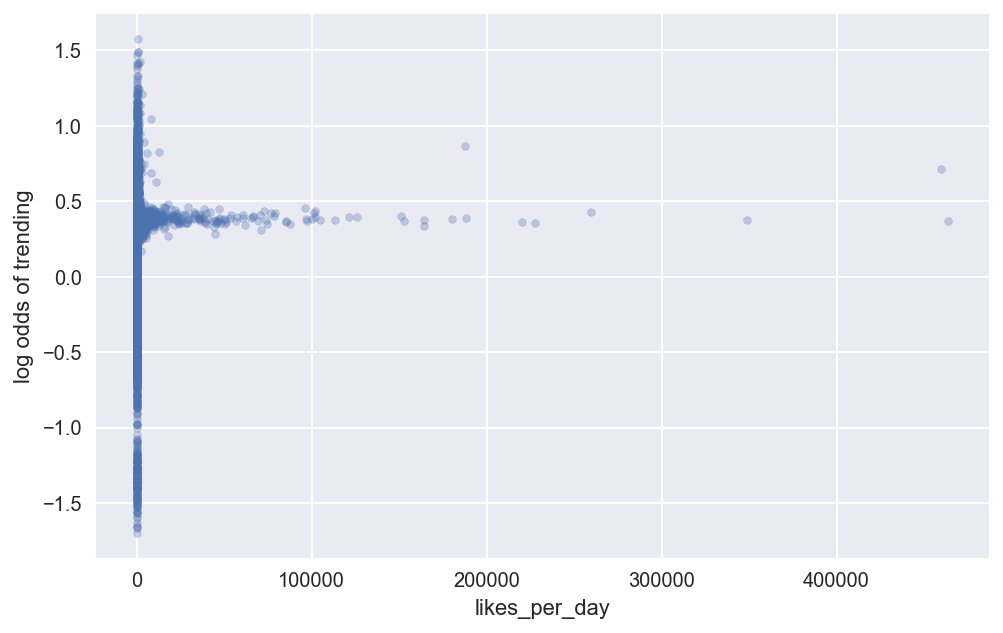

In [10]:
t = pd.DataFrame({'feat':X_trainec.likes_per_day, 
                  'shap':shap_values[1].T[3]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('likes_per_day'); plt.ylabel('log odds of trending')
plt.show()

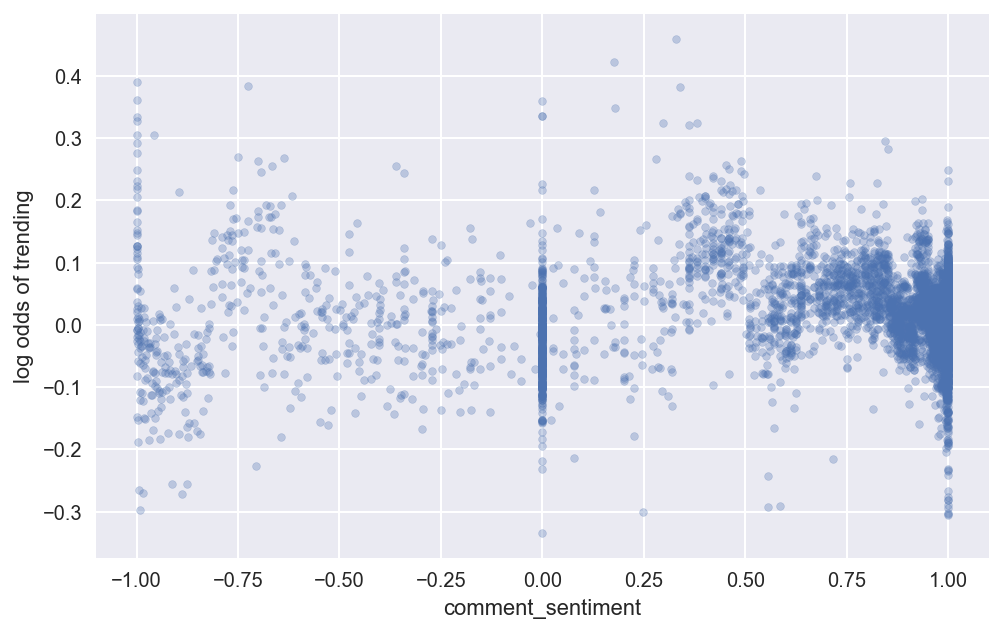

In [11]:
t = pd.DataFrame({'feat':X_trainec.comment_sentiment, 
                  'shap':shap_values[1].T[9]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('comment_sentiment'); plt.ylabel('log odds of trending')
plt.show()

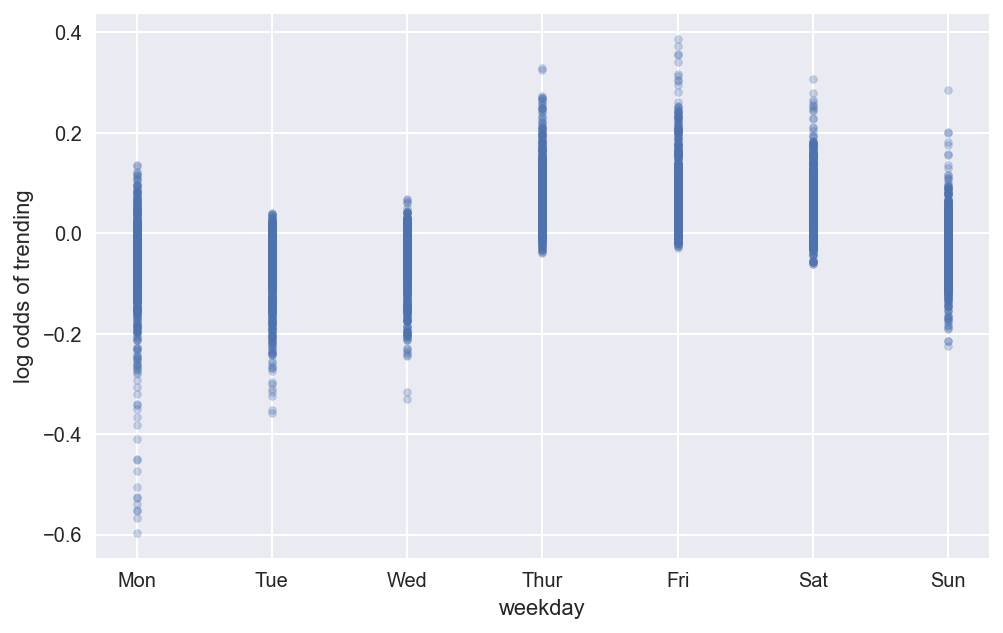

In [12]:
t = pd.DataFrame({'feat':X_trainec.weekday, 
                  'shap':shap_values[1].T[10]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday'); plt.ylabel('log odds of trending')
plt.show()

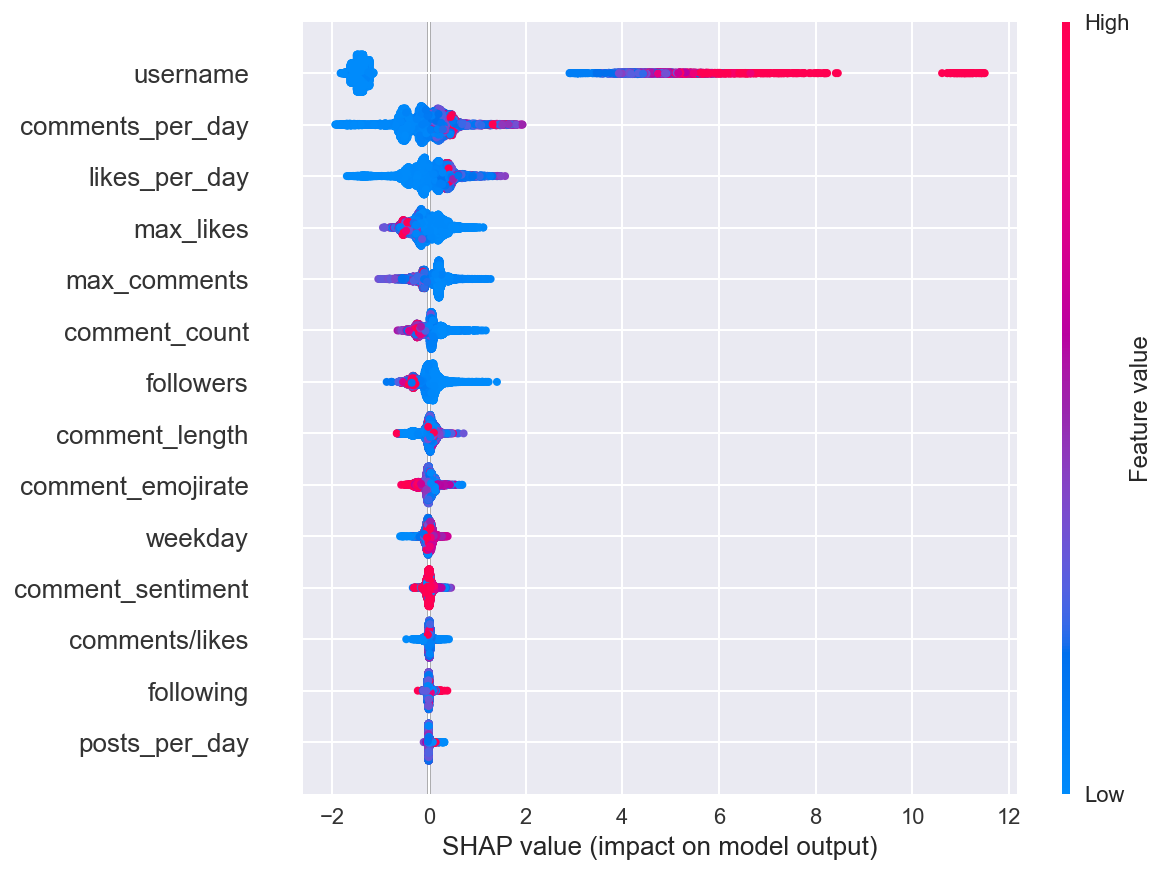

In [13]:
shap.summary_plot(shap_values[1], X_trainec)

In [16]:
post['pred'] = lgbm.predict_proba(X_ec_norm).T[1]
post.sort_values(by = 'pred', 
                 ascending = False)[['post_url', 'username', 'days_in_hashtag_top_section', 'pred', 'trending']].head(20)

,post_url,username,days_in_hashtag_top_section,pred,trending
11566,https://www.instagram.com/p/B_aHtncgiqY/,nur.rr,1,0.998430,1.0
11368,https://www.instagram.com/p/B_XUYo4KZN3/,outfitsofmunich,5,0.998218,1.0
11558,https://www.instagram.com/p/B_ajoxYo_t8/,jason.kural,2,0.997812,1.0
11369,https://www.instagram.com/p/B_XwpPvqfpG/,outfitsofmunich,5,0.997628,1.0
11606,https://www.instagram.com/p/B_ZzgYEKk3Q/,sonycozy,1,0.997552,1.0
11565,https://www.instagram.com/p/B_StSIwgtB3/,nur.rr,2,0.997301,1.0
11567,https://www.instagram.com/p/B_U5Sk6AhGm/,erdemorayli,4,0.996699,1.0
9295,https://www.instagram.com/p/B_aJzYhJNJl/,d.ave.y,20,0.996675,1.0
11603,https://www.instagram.com/p/B_cXdrtHURY/,peipay97,4,0.996468,1.0
11367,https://www.instagram.com/p/B_VFXPjKaZB/,outfitsofmunich,2,0.996446,1.0
